In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# conda update keras

In [ ]:
# permetrics 사용을 위한 코드 (conda install permetrics : package not found error)
!pip install git+https://github.com/thieu1995/permetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/thieu1995/permetrics to /tmp/pip-req-build-io6196kf
  Running command git clone -q https://github.com/thieu1995/permetrics /tmp/pip-req-build-io6196kf
  Created wheel for permetrics: filename=permetrics-1.3.0-py3-none-any.whl size=26351 sha256=3e4cef350850bc0629fe240296427e584382b3ffdbaf867cbbaa548019d2ea73
  Stored in directory: /tmp/pip-ephem-wheel-cache-23pphoif/wheels/e9/84/08/e76f6bf9b2ae02dbf0bbeb51d2fe300d87c7c8bb2d4443953c
Successfully built permetrics


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
# from keras.utils import plot_model

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D


#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os
os.chdir('/content/drive/MyDrive/신입기수 프로젝트/Dataset')

## 데이터 불러오기, 공통 전처리

In [ ]:
raw_data = pd.read_csv('newdata5.csv', encoding = 'cp949')
raw_data
# for jupyter
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/newdata5.csv

,날짜,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,2012-05-01 0:00,0.0,0.0,0.0,0.0,575.70,193.0,469.05,729.80,540.18,310.7,300.2,290.0,275.3
1,2012-05-01 0:10,0.0,0.0,0.0,0.0,575.30,199.0,498.00,731.48,540.18,314.7,300.2,290.0,275.3
2,2012-05-01 0:20,0.0,0.0,0.0,0.0,555.00,207.0,490.68,726.42,540.18,313.7,301.2,290.0,275.3
3,2012-05-01 0:30,0.0,0.0,0.0,0.0,575.70,215.0,476.21,726.42,552.17,311.7,301.2,290.0,276.3
4,2012-05-01 0:40,0.0,0.0,0.0,0.0,575.40,226.0,476.21,707.17,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10,0.0,0.0,0.0,0.0,258.67,407.0,319.84,-456.41,974.40,288.0,295.0,299.0,306.0
276332,2022-07-18 23:20,0.0,0.0,0.0,0.0,258.58,431.0,314.01,-717.30,1006.88,287.0,303.0,304.0,308.0
276333,2022-07-18 23:30,0.0,0.0,0.0,0.0,258.56,453.0,387.55,-843.37,1039.90,299.0,307.0,309.0,310.0
276334,2022-07-18 23:40,0.0,0.0,0.0,0.0,258.65,476.0,454.91,-1023.37,1073.46,309.0,311.0,314.0,312.0


In [ ]:
# 마지막 수위 부분 저장을 위한 copy본 만들어두기
raw_data_copy = raw_data.copy()


# 중복되는 컬럼 버리기
raw_data = raw_data.drop(columns = ['청담대교_수위', '잠수교_수위', '한강대교_수위', '행주대교_수위', '행주대교_유량'], axis = 1)
# 서울시 강수량 버리기
raw_data = raw_data.drop(columns = ['서울시_강수량'], axis = 1)

# 단변량으로 결측치 처리한 수위4개+유량1개 파일 가져오기
행주대교_유량 = pd.read_csv('CNN_전처리/행주대교_유량_2nd.csv', encoding = 'cp949')
행주대교_수위 = pd.read_csv('CNN_전처리/행주대교_수위_6th.csv', encoding = 'cp949')
한강대교_수위 = pd.read_csv('CNN_전처리/한강대교_수위.csv', encoding = 'cp949')
잠수교_수위 = pd.read_csv('CNN_전처리/잠수교_수위.csv', encoding = 'cp949')
청담대교_수위 = pd.read_csv('CNN_전처리/청담대교_수위.csv', encoding = 'cp949')

# for jupyter
# 행주대교_유량 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/행주대교_유량_2nd.csv', encoding = 'cp949')
# 행주대교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/행주대교_수위_6th.csv', encoding = 'cp949')
# 한강대교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/한강대교_수위.csv', encoding = 'cp949')
# 잠수교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/잠수교_수위.csv', encoding = 'cp949')
# 청담대교_수위 = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/CNN_전처리/청담대교_수위.csv', encoding = 'cp949')

# raw_data에 추가하기
raw_data = pd.concat([raw_data, 행주대교_유량, 청담대교_수위, 잠수교_수위, 한강대교_수위, 행주대교_수위], axis = 1)

# 마지막 수위 부분 0 -> 정답값으로 채우기
raw_data.iloc[-6912:, [-4, -3, -2, -1]] = raw_data_copy.iloc[-6912:, [-4, -3, -2, -1]]

# 날짜를 index로 바꾸고 dtype을 datetime으로 바꾸기
raw_data.set_index(keys = ['날짜'], inplace = True)
raw_data.index = pd.to_datetime(raw_data.index, format = '%Y-%m-%d %H:%M')

# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,대곡교_강수량,진관교_강수량,송정동_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
날짜,,,,,,,,,,,,,,,,
2012-05-01 00:00:00,0.0,0.0,0.0,0.058462,0.191781,0.024640,0.147596,0.011070,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
2012-05-01 00:10:00,0.0,0.0,0.0,0.058447,0.199253,0.027800,0.147654,0.011070,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2012-05-01 00:20:00,0.0,0.0,0.0,0.057689,0.209215,0.027001,0.147478,0.011070,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
2012-05-01 00:30:00,0.0,0.0,0.0,0.058462,0.219178,0.025421,0.147478,0.011475,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
2012-05-01 00:40:00,0.0,0.0,0.0,0.058451,0.232877,0.025421,0.146810,0.011883,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.0,0.0,0.0,0.046624,0.458281,0.008355,0.106425,0.025719,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
2022-07-18 23:20:00,0.0,0.0,0.0,0.046621,0.488169,0.007719,0.097370,0.026815,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
2022-07-18 23:30:00,0.0,0.0,0.0,0.046620,0.515567,0.015745,0.092994,0.027929,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0


## train / test data 생성

In [ ]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████| 11/11 [03:42<00:00, 20.23s/it]


In [ ]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
#ytest = ydata_[-6912:]

ytest_list = sorted(glob("submission 임시/*.csv"))
ytest = []
# for jupyter
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/Dataset/submission 임시/*.csv

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(269358, 6, 12)
(269358, 4)
(6912, 6, 12)
(6912, 4)


## 모델 정의

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def nse(y_true, y_pred):
    return (1-(K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)))


if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.005) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu', input_shape=(w, xtrain.shape[2])))
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(BatchNormalization(momentum=0.99, scale=False, center=False))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 6, 64)             1600      
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 384)           0         
 or)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 1, 200)            468000    
                                                                 
 batch_normalization_1 (Batc  (None, 1, 200)           400       
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 1, 200)           

In [ ]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

NameError: ignored

In [ ]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=0.001)

## 학습

In [ ]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 69s 79ms/step - loss: 34.3152 - nse: 0.1455 - val_loss: 18.4032 - val_nse: -0.0485 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 63s 78ms/step - loss: 19.1934 - nse: 0.8524 - val_loss: 15.2882 - val_nse: 0.3998 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 63s 78ms/step - loss: 16.8530 - nse: 0.8911 - val_loss: 47.1025 - val_nse: -5.5979 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 63s 79ms/step - loss: 14.2946 - nse: 0.9228 - val_loss: 12.3589 - val_nse: 0.5460 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 63s 79ms/step - loss: 12.6472 - nse: 0.9401 - val_loss: 19.2408 - val_nse: -0.1350 - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 64s 80ms/step - loss: 11.8729 - nse: 0.9467 - val_loss: 25.9282 - val_nse: -0.9411 - lr: 0.0100
Epoch 7/100
802/802 [==============================] - 63s 79ms/step - loss: 10.9167 - nse: 0.95

## 평가

In [ ]:
xtest.shape

(6912, 6, 12)

In [ ]:
keras_model_best

In [ ]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest)

keras_model_best.evaluate(xtest,ytest)

ValueError: ignored

## 학습 과정 시각화

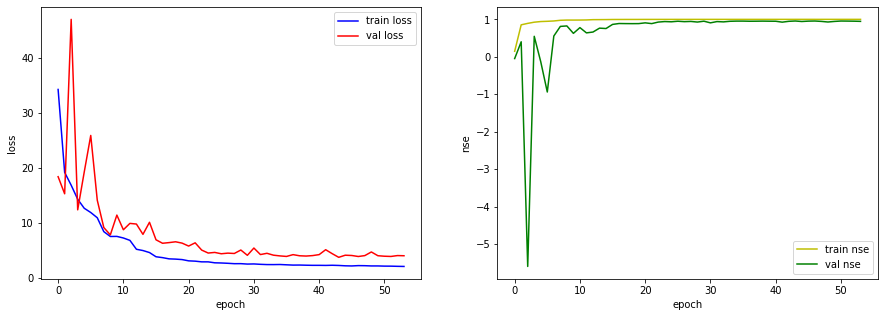

In [ ]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

In [ ]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

NameError: ignored

## 점수 확인

In [ ]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

NameError: ignored

## 점수 확인

In [ ]:
sample_submission = pd.read_csv("Copy of sample_submission.csv")
# for jupyter
# /Volumes/GoogleDrive/.shortcut-targets-by-id/1rUx7_7LmBqAQTbWEWVTGvw0_d0v6N2ZT/신입기수 프로젝트/DACON/competition_data/sample_submission.csv

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("다영_0826_CNN_LSTM/전처리_단변량_12.csv", index = False)